# Learning rates regression

Notebook that explores the optimal learning rate for regression.

In [18]:
# Importing some libraries

# Torch 
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# Other libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import jaccard_score

**Unpacking the data**

In this first part, some functions are defined to unpack the data.

In [19]:
class CPU_Unpickler(pickle.Unpickler):
    # to avoid errors that occur when loading pickle files on cpu that were originally saved using a gpu
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [20]:
# Function that enables you to unpack a certain chunk of data
def load_chunk_file(file_path, chunk_i):
    with open(file_path+f'chunk_{chunk_i}', 'rb') as file:
            loaded_data = CPU_Unpickler(file).load()
            
    return loaded_data

In [21]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    mask_gamma_ray = np.array((data_noisy_all[1]==1))
    data_noisy_chunk = np.array(data_noisy_all[0])[mask_gamma_ray]
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])[mask_gamma_ray]
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
# Get it in the right shape
data_noisy = data_noisy_tot.reshape(64*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(64*chunk_tot, 56, 56)


**Data Preperation**

In [22]:
# Now with a minimum of 0

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)
data_true_nonan = np.nan_to_num(data_true)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_nonan_flat = data_true_nonan.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
data_noisy_arr[np.nan_to_num(data_noisy_arr)<0] = 0


pix_max_noisy = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num(data_noisy_arr/pix_max_noisy)
data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())


# Now normalize the true data in the same way as the noisy data

data_true_arr = data_true_nonan_flat[images_high_mask]
pix_max_true = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis]
data_true_norm = np.nan_to_num(data_true_arr/pix_max_true)
data_true_tensor = (torch.from_numpy(data_true_norm).float())

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()

data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:]
data_true_test = data_true_tensor[idx_split:]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:]
data_true_test_im = data_true_tensor_im[idx_split:]


**Models**

In [23]:
# AE with 4 layers

class AE4(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

**Fitting functions**

In [24]:
# Functions and definitions for 
n_epochs = 3

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

batch_size=1
weight = 2

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train):
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.mse_loss(output, true)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.6f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            loss = F.mse_loss(output, true)
            test_loss += loss.item()
    
    test_loss /= len(data_noisy_test)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.6f}'.format(test_loss))

**Testing the learning rates**

In [25]:
lrs = np.logspace(-1, -5, 5)
n_epochs = 30

train_losses_all = []
test_losses_all = []
IOU_list_all = []

for lr in lrs:
    print()
    print(f"Learning rate: {lr}")
    network = AE4()
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*100 for i in range(n_epochs + 1)]
    IOU_list = []
    test()
    for epoch in range(1, n_epochs + 1):
        train(epoch)
        test()
        
    train_losses_all.append(train_losses)
    test_losses_all.append(test_losses)
    IOU_list_all.append(IOU_list)
    
train_losses_arr = np.array(train_losses_all)
test_losses_arr = np.array(test_losses_all)
IOU_arr = np.array(IOU_list_all)


Learning rate: 0.1

Test set: Avg. loss: 0.052262
Training set: Avg. loss: 42246318.882582

Test set: Avg. loss: 0.003400
Training set: Avg. loss: 0.002218

Test set: Avg. loss: 0.001280
Training set: Avg. loss: 0.002007

Test set: Avg. loss: 0.001270
Training set: Avg. loss: 0.002393

Test set: Avg. loss: 0.001342
Training set: Avg. loss: 0.001931

Test set: Avg. loss: 0.001832
Training set: Avg. loss: 0.001403

Test set: Avg. loss: 0.001216
Training set: Avg. loss: 0.001375

Test set: Avg. loss: 0.001167
Training set: Avg. loss: 0.001393

Test set: Avg. loss: 0.001184
Training set: Avg. loss: 0.001393

Test set: Avg. loss: 0.001161
Training set: Avg. loss: 0.001390

Test set: Avg. loss: 0.001184
Training set: Avg. loss: 0.001393

Test set: Avg. loss: 0.001187
Training set: Avg. loss: 0.001390

Test set: Avg. loss: 0.001317
Training set: Avg. loss: 0.001387

Test set: Avg. loss: 0.001299
Training set: Avg. loss: 0.001393

Test set: Avg. loss: 0.001361
Training set: Avg. loss: 0.00139

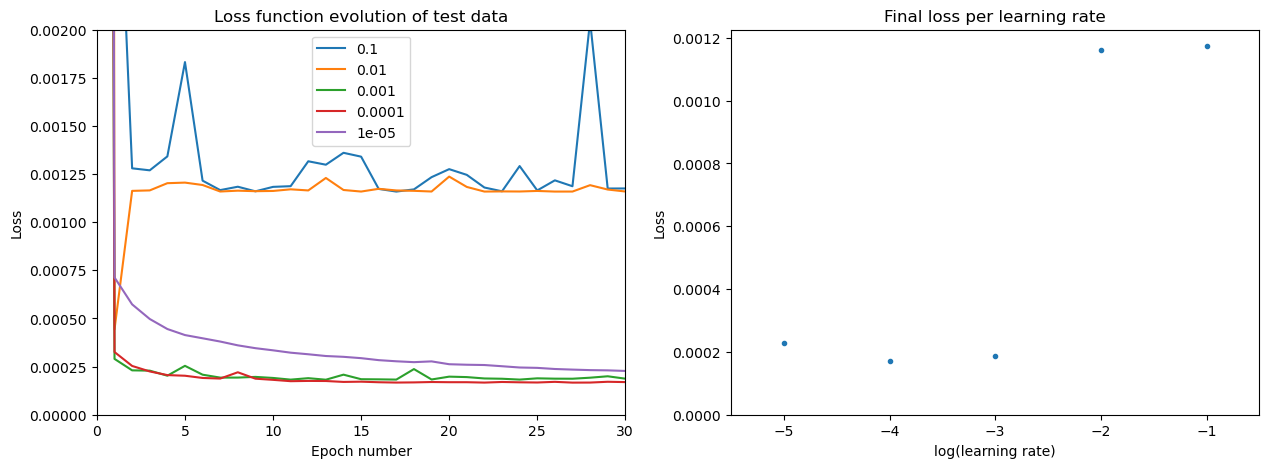

In [26]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

i=0
for lr in lrs:
    axs[0].plot(np.arange(0, n_epochs+1, 1), test_losses_arr[i], label=lr)
    
    i=i+1
    
axs[0].legend()
axs[0].set_xlim(0,30)
axs[0].set_ylim(0,0.002)
axs[0].set_xlabel("Epoch number")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss function evolution of test data")

axs[1].errorbar(np.log10(lrs), np.mean(test_losses_arr[:,-1:], axis=1), yerr=np.std(test_losses_arr[:, -1:], axis=1), fmt='.')
axs[1].set_xlim(-5.5,-0.5)
axs[1].set_ylim(0,)
axs[1].set_xlabel("log(learning rate)")
axs[1].set_ylabel("Loss")
axs[1].set_title("Final loss per learning rate")

plt.show()

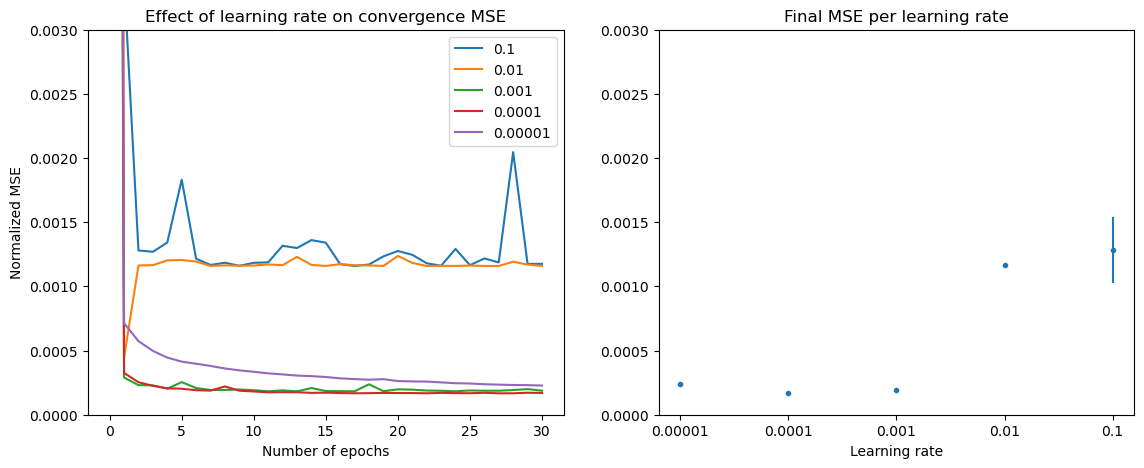

In [37]:
fig_lr, axs = plt.subplots(1,2,figsize=(13.5,5))


axs[0].plot(np.arange(0, n_epochs+1, 1), test_losses_arr[0], label='{:.1f}'.format(lrs[0]))    
axs[0].plot(np.arange(0, n_epochs+1, 1), test_losses_arr[1], label='{:.2f}'.format(lrs[1]))   
axs[0].plot(np.arange(0, n_epochs+1, 1), test_losses_arr[2], label='{:.3f}'.format(lrs[2]))   
axs[0].plot(np.arange(0, n_epochs+1, 1), test_losses_arr[3], label='{:.4f}'.format(lrs[3]))   
axs[0].plot(np.arange(0, n_epochs+1, 1), test_losses_arr[4], label='{:.5f}'.format(lrs[4]))   

axs[0].legend()
axs[0].set_ylim(0,0.003)
axs[0].set_xlabel("Number of epochs")
axs[0].set_ylabel("Normalized MSE")
axs[0].set_title("Effect of learning rate on convergence MSE")

axs[1].errorbar(np.log10(lrs), np.mean(test_losses_arr[:, -10:], axis=1), yerr=np.std(test_losses_arr[:, -10:], axis=1), fmt='.')
axs[1].set_xlabel("Learning rate")
axs[1].set_ylim(0,0.003)
axs[1].set_xticks([-5,-4,-3,-2,-1], ['{:.5f}'.format(lrs[4]), 0.0001, 0.001, 0.01, 0.1])
axs[1].set_title("Final MSE per learning rate")

plt.show()

fig_lr.savefig("images/LearningRateReg.pdf")